In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from assigment_utils import *

%matplotlib widget
tf.autograph.set_verbosity(0)
tf.keras.backend.set_floatx("float64")
tf.get_logger().setLevel("ERROR")

2025-07-08 08:15:31.885835: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-08 08:15:32.184690: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751944532.290477     503 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751944532.322276     503 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751944532.563438     503 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# Generate some data
X,y,x_ideal,y_ideal = gen_data(18, 2, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

X.shape (18,) y.shape (18,)


In [3]:
xtr, xtt, ytr, ytt = train_test_split(X, y, test_size=0.33, random_state=1)

In [4]:
print(xtr.shape, ytr.shape)
print(xtt.shape, ytt.shape)

(12,) (12,)
(6,) (6,)


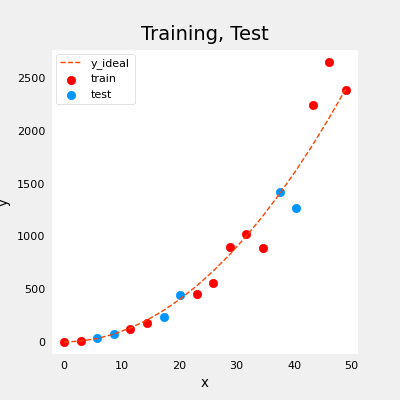

In [5]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(xtr, ytr, color = "red",           label="train")
ax.scatter(xtt, ytt,   color = dlc["dlblue"],   label="test")
ax.legend(loc='upper left')
plt.show()

In [6]:
def eval_mse(y, yhat):
    m = len(y)
    mse = 0
    for i in range(m):
        mse += (yhat[i] - y[i]) **2
    mse /= 2*m
    return mse

In [7]:
y_hat = np.array([2.4, 4.2])
y_tmp = np.array([2.3, 4.1])
eval_mse(y_hat, y_tmp)

np.float64(0.0050000000000000305)

In [8]:
degree = 10
lm1 = lin_model(degree)
lm1.fit(xtr, ytr)

yhat = lm1.predict(xtr)
err_train = lm1.mse(ytr, yhat)

yhat = lm1.predict(xtt)
err_test = lm1.mse(ytt, yhat)

In [9]:
print(f"training err {err_train:0.2f}, test err {err_test:0.2f}")

training err 58.01, test err 171215.01


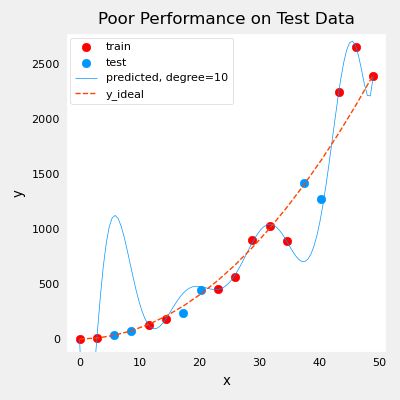

In [10]:
# plot predictions over data range 
x = np.linspace(0,int(X.max()),100)  # predict values for plot
y_pred = lm1.predict(x).reshape(-1,1)

plt_train_test(xtr, ytr, xtt, ytt, x, y_pred, x_ideal, y_ideal, degree)

In [11]:
# Generate some data
X,y,x_ideal,y_ideal = gen_data(40, 5, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

xtr, x_, ytr, y_ = train_test_split(X, y, test_size=0.40, random_state=1)
xcv, xtt, ycv, ytt = train_test_split(x_, y_, test_size=0.5, random_state=1)

del x_, y_

X.shape (40,) y.shape (40,)


In [12]:
print("X_train.shape", xtr.shape, "y_train.shape", ytr.shape)
print("X_cv.shape", xcv.shape, "y_cv.shape", ycv.shape)
print("X_test.shape", xtt.shape, "y_test.shape", ytt.shape)

X_train.shape (24,) y_train.shape (24,)
X_cv.shape (8,) y_cv.shape (8,)
X_test.shape (8,) y_test.shape (8,)


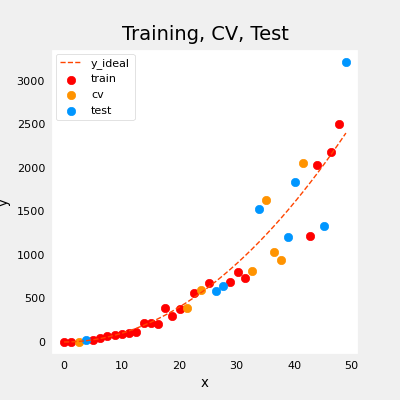

In [13]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, CV, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(xtr, ytr, color = "red",           label="train")
ax.scatter(xcv, ycv,       color = dlc["dlorange"], label="cv")
ax.scatter(xtt, ytt,   color = dlc["dlblue"],   label="test")
ax.legend(loc='upper left')
plt.show()

In [14]:
max_deg = 9
err_train = np.zeros(max_deg)
err_cv = np.zeros(max_deg)
x = np.linspace(0,int(X.max()),100)  
y_pred = np.zeros((100,max_deg)) 

for degree in range(max_deg):
    lm = lin_model(degree+1)
    lm.fit(xtr,ytr)
    yhat = lm.predict(xtr)
    err_train[degree] = lm.mse(ytr, yhat)
    yhat = lm.predict(xcv)
    err_cv[degree] = lm.mse(ycv, yhat)
    y_pred[:, degree] = lm.predict(x)

optimal_deg = np.argmin(err_cv)+1

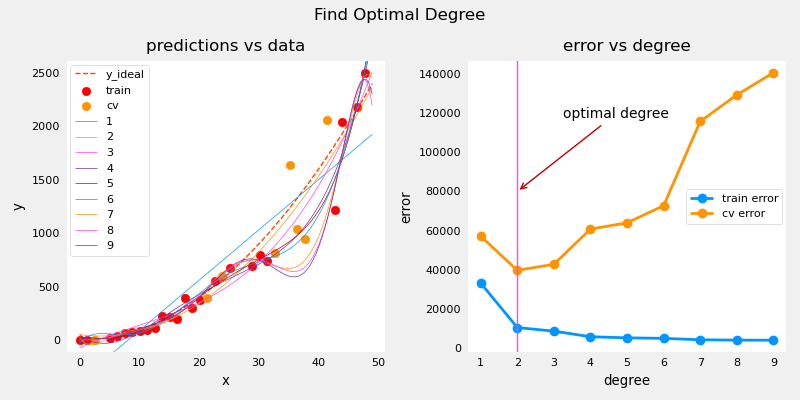

In [15]:
plt.close("all")
plt_optimal_degree(xtr, ytr, xcv, ycv, x, y_pred, x_ideal, y_ideal, 
                   err_train, err_cv, optimal_deg, max_deg)

In [16]:
lambda_range = np.array([0.0, 1e-6, 1e-5, 1e-4,1e-3,1e-2, 1e-1,1,10,100])
num_steps = len(lambda_range)

degree = 10
err_train = np.zeros(num_steps)
err_cv = np.zeros(num_steps)
x = np.linspace(0,int(X.max()),100)  
y_pred = np.zeros((100,num_steps)) 

for i in range(num_steps):
    
    lm = lin_model(degree, regularization=True, lambda_=lambda_range[i])
    lm.fit(xtr,ytr)
    yhat = lm.predict(xtr)
    err_train[i] = lm.mse(ytr, yhat)
    yhat = lm.predict(xcv)
    err_cv[i] = lm.mse(ycv, yhat)
    y_pred[:, i] = lm.predict(x)

optimal_reg_lambda = np.argmin(err_cv)+1

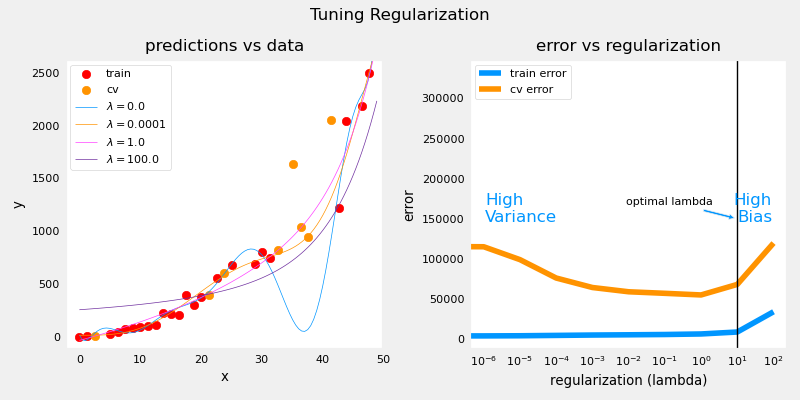

In [17]:
plt.close("all")
plt_tune_regularization(xtr, ytr, xcv, ycv, x, y_pred, err_train, err_cv, optimal_reg_lambda, lambda_range)

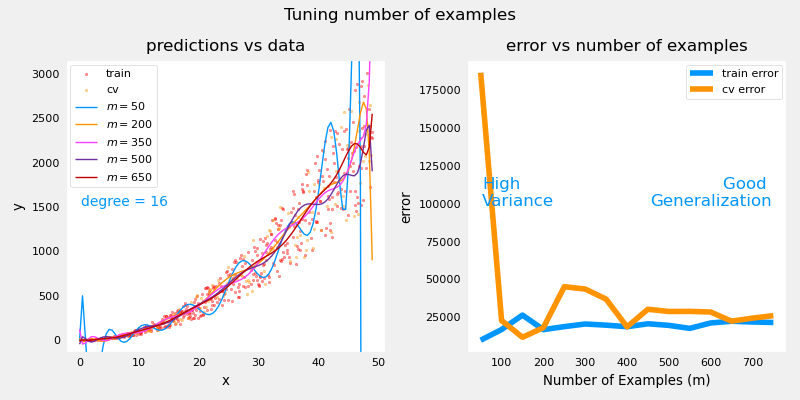

In [18]:
X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range,degree = tune_m()
plt_tune_m(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range, degree)

### Evaluating Models

In [19]:
# Generate and split data set
X, y, centers, classes, std = gen_blobs()

# split the data. Large CV population for demonstration
xtr, X_, ytr, y_ = train_test_split(X,y,test_size=0.50, random_state=1)
xcv, xtt, ycv, ytt = train_test_split(X_,y_,test_size=0.20, random_state=1)
print("X_train.shape:", xtr.shape, "X_cv.shape:", xcv.shape, "X_test.shape:", xtt.shape)

X_train.shape: (400, 2) X_cv.shape: (320, 2) X_test.shape: (80, 2)


In [20]:
def cat_err(yhat, y):
    m = len(y)
    incorrect = 0
    for i in range(m):
        if yhay[i] != y[i]:
            incorrect += 1
    c_err += incorrect / m
    return c_err

In [21]:
y_hat = np.array([1, 2, 0])
y_tmp = np.array([1, 2, 3])
print(f"categorization error {np.squeeze(eval_cat_err(y_hat, y_tmp)):0.3f}, expected:0.333" )
y_hat = np.array([[1], [2], [0], [3]])
y_tmp = np.array([[1], [2], [1], [3]])

categorization error 0.333, expected:0.333


In [22]:
tf.random.set_seed(1234)
complex_model = Sequential([
    Dense(120, activation='relu'),
    Dense(40, activation='relu'),
    Dense(6, activation="linear")
])

complex_model.compile(
    loss = SparseCategoricalCrossentropy(from_logits=True),
    optimizer= Adam(0.01)
)

complex_model.fit(xtr,ytr, epochs=1000)

Epoch 1/1000


I0000 00:00:1751944538.989103     503 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1751944539.838308     589 service.cc:152] XLA service 0x748f4c004450 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751944539.838427     589 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-07-08 08:15:39.896472: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1751944543.652882     589 cuda_dnn.cc:529] Loaded cuDNN version 90701


 1/13 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - loss: 1.8220

I0000 00:00:1751944540.696280     589 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 1.3790
Epoch 2/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4295 
Epoch 3/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3304 
Epoch 4/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2617 
Epoch 5/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2302 
Epoch 6/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2106 
Epoch 7/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2067 
Epoch 8/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2040 
Epoch 9/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1965 
Epoch 10/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1960 
Epoch 11/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1918 
Epoch 12/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1913 
Epoch 13/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1925 
Epoch 14/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1871 
Epoch 15/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - l

In [23]:
complex_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 120)            │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 40)             │         4,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           246 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,340 (127.66 KB)

 Trainable params: 5,446 (42.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,894 (85.11 KB)

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


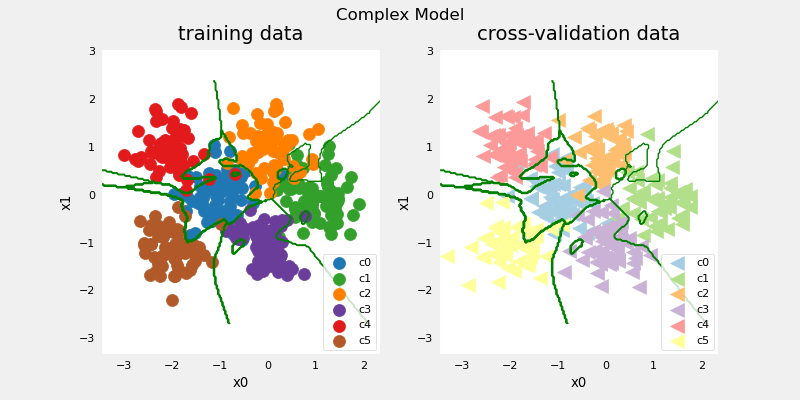

In [24]:
model_predict = lambda Xl: np.argmax(tf.nn.softmax(complex_model.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict,xtr,ytr, classes, xcv, ycv, suptitle="Complex Model")

In [25]:
training_cerr_complex = eval_cat_err(ytr, model_predict(xtr))
cv_cerr_complex = eval_cat_err(ycv, model_predict(xcv))
print(f"categorization error, training, complex model: {training_cerr_complex:0.3f}")
print(f"categorization error, cv,       complex model: {cv_cerr_complex:0.3f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
categorization error, training, complex model: 0.005
categorization error, cv,       complex model: 0.106


In [26]:
simple_model= Sequential([
    Dense(6, activation='relu'),
    Dense(6, activation='linear')
])

simple_model.compile(
    loss= SparseCategoricalCrossentropy(from_logits=True),
    optimizer= Adam(0.01)
)

simple_model.fit(
    xtr, ytr, epochs=1000
)

Epoch 1/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 1.8645  
Epoch 2/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6310 
Epoch 3/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4651 
Epoch 4/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3096 
Epoch 5/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1638 
Epoch 6/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0313 
Epoch 7/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9102 
Epoch 8/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7919 
Epoch 9/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6686 
Epoch 10/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5610 
Epoch 11/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4854 
Epoch 12/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4364 
Epoch 13/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4039 
Epoch 14/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3798 
Epoch 15/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 

In [27]:
simple_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 6)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │            42 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 182 (1.42 KB)

 Trainable params: 60 (480.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 122 (976.00 B)

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


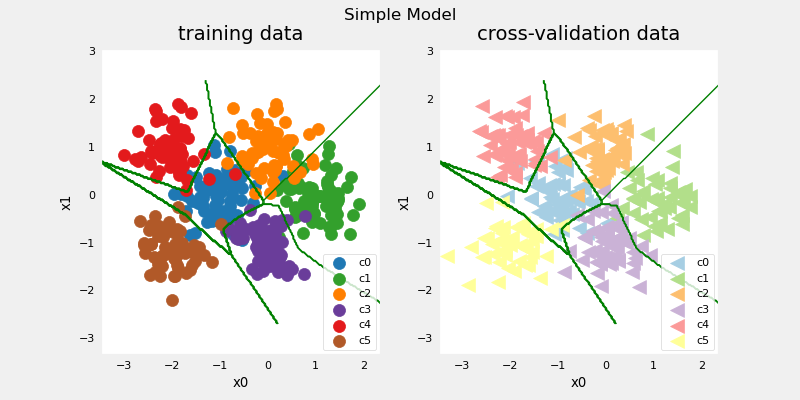

In [28]:
model_predict_s = lambda Xl: np.argmax(tf.nn.softmax(simple_model.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict_s,xtr,ytr, classes, xcv, ycv, suptitle="Simple Model")

In [29]:
training_cerr_simple = eval_cat_err(ytr, model_predict_s(xtr))
cv_cerr_simple = eval_cat_err(ycv, model_predict_s(xcv))
print(f"categorization error, training, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
categorization error, training, simple model, 0.068, complex model: 0.005
categorization error, cv,       simple model, 0.075, complex model: 0.106


In [30]:
reg_comp_model = Sequential([
    Dense(120, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.1)),
    Dense(40, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.1)),
    Dense(6, activation='linear'),
])

reg_comp_model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=Adam(0.01)
)

reg_comp_model.fit(xtr, ytr, epochs=1000)

Epoch 1/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 5.8243
Epoch 2/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7032 
Epoch 3/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3129 
Epoch 4/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0764 
Epoch 5/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9778 
Epoch 6/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9262 
Epoch 7/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8806 
Epoch 8/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8506 
Epoch 9/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8334
Epoch 10/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8144 
Epoch 11/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7714 
Epoch 12/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7406 
Epoch 13/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7219 
Epoch 14/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7094 
Epoch 15/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s

In [31]:
reg_comp_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 120)            │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 40)             │         4,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           246 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,340 (127.66 KB)

 Trainable params: 5,446 (42.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,894 (85.11 KB)

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 68us/step


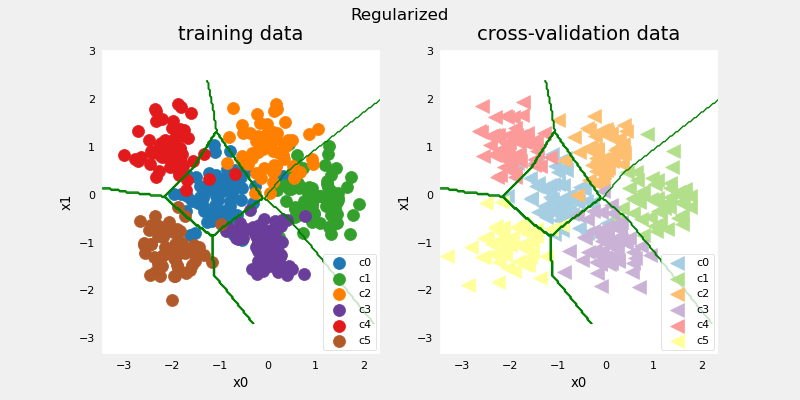

In [32]:
model_predict_r = lambda Xl: np.argmax(tf.nn.softmax(reg_comp_model.predict(Xl)).numpy(),axis=1)
 
plt_nn(model_predict_r, xtr,ytr, classes, xcv, ycv, suptitle="Regularized")

In [33]:
training_cerr_reg = eval_cat_err(ytr, model_predict_r(xtr))
cv_cerr_reg = eval_cat_err(ycv, model_predict_r(xcv))
test_cerr_reg = eval_cat_err(ytt, model_predict_r(xtt))
print(f"categorization error, training, regularized: {training_cerr_reg:0.3f}, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       regularized: {cv_cerr_reg:0.3f}, simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
categorization error, training, regularized: 0.065, simple model, 0.068, complex model: 0.005
categorization error, cv,       regularized: 0.066, simple model, 0.075, complex model: 0.106


In [35]:
tf.random.set_seed(1234)
lambdas = [0.0, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3]
models = [None] *len(lambdas)

for i in range(len(lambdas)):
    models[i] = Sequential([
        Dense(120, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(lambdas[i])),
        Dense(40, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(lambdas[i])),
        Dense(6)
    ])

    models[i].compile(
        loss = SparseCategoricalCrossentropy(from_logits=True),
        optimizer = Adam(0.01) 
    )

    models[i].fit(xtr,ytr, epochs=1000)

    print(f"Finished lambda = {lambdas[i]}")

Epoch 1/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 1.3681
Epoch 2/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4200 
Epoch 3/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3216 
Epoch 4/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2529 
Epoch 5/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2286 
Epoch 6/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2212 
Epoch 7/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2133 
Epoch 8/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2052 
Epoch 9/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1983 
Epoch 10/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1997 
Epoch 11/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1994 
Epoch 12/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1952 
Epoch 13/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1943 
Epoch 14/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1931 
Epoch 15/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



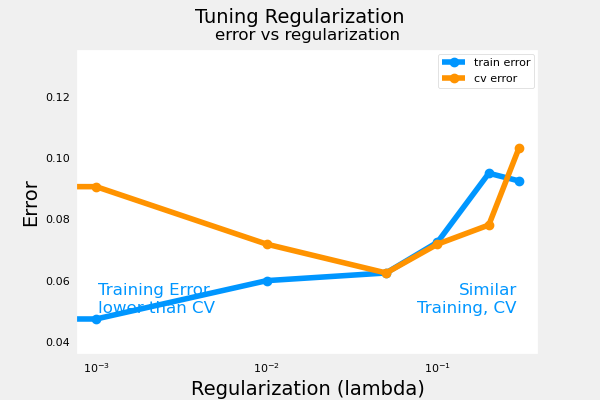

In [36]:
plot_iterate(lambdas, models, xtr, ytr, xcv, ycv)

1050/1050 ━━━━━━━━━━━━━━━━━━━━ -0s -197us/step
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


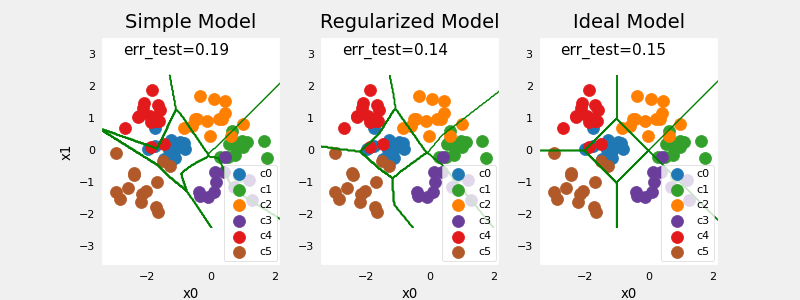

In [37]:
plt_compare(xtt,ytt, classes, model_predict_s, model_predict_r, centers)